# WhatsApp group Chat data preprocessing

We wanted to incorporate questions and answers from a Whatsapp group for support of new students.  


In [1]:
import re, json
from datetime import datetime, timedelta
import pandas as pd
from duckdb import sql as sqldf

from plotly import express as px
from plotly import graph_objs as go

In [2]:
# these are only needed for dispaying plots on github preview
# comment these out to enable interactive plots in jupyter
import plotly.io as pio
pio.renderers.default = "svg"

## Export the WhatsApp chat data
You can find instructions anywhere on the internet  
Save it as _chat.txt in the same directory


## Load WhatsApp export
For the actual competition we've used an actual data from one of the support groups in our college.  
But we don't want to share this data with the world, so we're not publishing it.

There are similar datasets available on kaggle, so we will use one of them for the demonstration:  
[https://www.kaggle.com/datasets/kamyamehra/chat-dataset]()  

A row in this raw caht dump generally looks like: 

`[24/04/24, 7:54:07 PM] ~ Jigyasu: Hello, I am Jigyasu from NIT Agartala`

Below are the regexes needed to parse this dump.  
Be advised that different versions of whatsapp have slightly different row format. Additionally the datetime format seems to depend on the locale defined in the smartphone of the person who exported it.  
This means that you will need to adapt these regexes to your particular dump.


In [3]:
with open("_chat.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

# ambiguous_chars_pattern = r'[\u202b\u202c\u200f]' #rtl languages
bad_space_patt = r'[\u202f]'
bad_empty_patt = r'[\u202a\u202b\u202c\u200e\u200f]'


date_patt = r'([0-9]{1,2}\/[0-9]{1,2}\/[0-9]{2,4})'
time_patt = r'([0-9]{1,2}:[0-9]{2}:[0-9]{2}\s*[AaPp][Mm])'
auth_patt = r'(?:~)?\s*([^:]+)'
text_patt = r'(.*)'
full_patt = f'^\[{date_patt},\s*{time_patt}\]\s*{auth_patt}:\s*{text_patt}$'
line_re = re.compile(full_patt)

print(full_patt)

^\[([0-9]{1,2}\/[0-9]{1,2}\/[0-9]{2,4}),\s*([0-9]{1,2}:[0-9]{2}:[0-9]{2}\s*[AaPp][Mm])\]\s*(?:~)?\s*([^:]+):\s*(.*)$


In [4]:
dt_format = "%d/%m/%y %H:%M:%S %p"

rows = []
row = {}

for raw_line in raw_text.splitlines():
    raw_line = re.sub(bad_space_patt, ' ', raw_line) 
    raw_line = re.sub(bad_empty_patt, '', raw_line) 
    m = line_re.match(raw_line)
    if m:
        rows.append(row)       
        
        date_str, time_str, author, text = m.groups()
        dt = datetime.strptime(f"{date_str} {time_str}", dt_format)
        row = {"timestamp": dt, "author": author.strip(), "text": text.strip()}
        
    else:
        row["text"] += '\n' + raw_line
print(len(rows))
rows[:3]

5414


[{},
 {'timestamp': datetime.datetime(2024, 4, 24, 7, 32, 47),
  'author': 'Campus Mantri 2024-25 (Unofficial) April',
  'text': 'Messages and calls are end-to-end encrypted. No one outside of this chat, not even WhatsApp, can read or listen to them.'},
 {'timestamp': datetime.datetime(2024, 4, 24, 7, 32, 47),
  'author': 'Amritaa Sethi Mam Gfg',
  'text': 'Amritaa Sethi Mam Gfg created this group'}]

In [5]:
df = pd.DataFrame(rows[1:]).sort_values("timestamp").reset_index(drop=True)

In [6]:
df[30:].head(30)

,timestamp,author,text
30,2024-04-24 07:50:26,Chanchal,Amritaa Sethi Mam Gfg added ~ Chanchal
31,2024-04-24 07:50:29,Name,https://www.linkedin.com/in/nanda-kishore-7290...
32,2024-04-24 07:50:31,Twinkle Rana,What is going on?
33,2024-04-24 07:50:39,Mukilan 💙,Amritaa Sethi Mam Gfg added ~ Mukilan 💙
34,2024-04-24 07:50:42,Ankit.exe,https://www.linkedin.com/in/coding-ankit/
35,2024-04-24 07:50:57,~Ansh Raj✨️,https://www.linkedin.com/in/anshra106?utm_sour...
36,2024-04-24 07:51:02,Nitin,https://www.linkedin.com/in/cyberrk
37,2024-04-24 07:51:04,Name,Sharing LinkedIn ID if you wanna connect
38,2024-04-24 07:51:05,Kashvi,https://www.linkedin.com/in/kashvi-bhanderi-a7...
39,2024-04-24 07:51:11,Maulik Parmar,LinkedIn profile shareing


In [7]:
df['date'] = df["timestamp"].dt.date
df['time'] = df["timestamp"].dt.time
df['daytime'] = df.time.apply(lambda dt : dt.hour*60*60 + dt.minute*60 + dt.second)


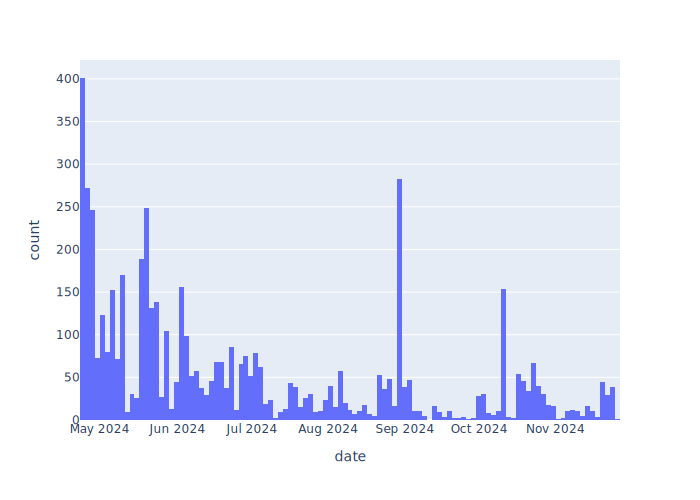

In [8]:
px.histogram(df, x = "date", nbins=df.date.nunique())

## Detect staff 
In the original data, we know who the staff are.  

For this public data we'll just assume that several most active users are the staff.

In [9]:
q = r"""SELECT author, count(text) as cnt

        FROM df
        
        group by author
        order by cnt desc
        ;""" 

userstats = sqldf(q).df()
userstats

,author,cnt
0,Aman Sir Gfg Interview,310
1,Nikhil Sharma,288
2,.,249
3,Aadil Latif,213
4,Vipul Kumar,145
...,...,...
196,Annanya Gali,1
197,Chaturya,1
198,+91 74149 71487,1
199,+91 94861 58981,1


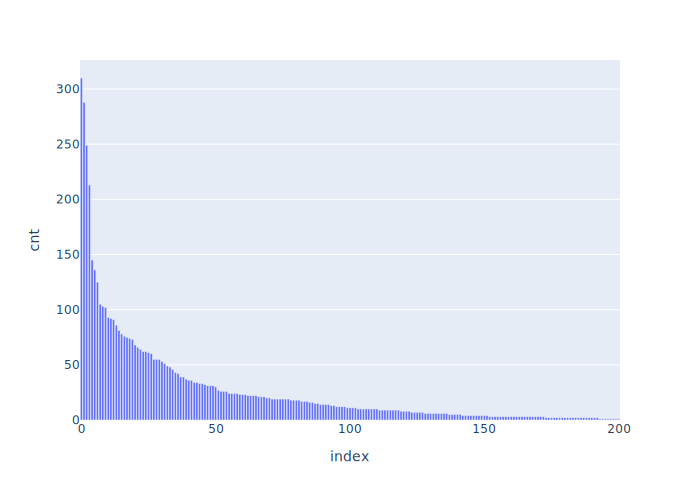

In [10]:
px.bar(userstats, x = userstats.index, y = "cnt", hover_data=["author"])

In [11]:
staff_names = set(userstats[:4].author)
staff_names

{'.', 'Aadil Latif', 'Aman Sir Gfg Interview', 'Nikhil Sharma'}

In [12]:
staff_names = {'Amritaa Sethi Mam Gfg','Aman Sir Gfg Interview', 'Nikhil Sharma', '.', 'Aadil Latif'}

df["role"] = df["author"].apply(lambda a: "staff" if a in staff_names else "student")


In [13]:
df

,timestamp,author,text,date,time,daytime,role
0,2024-04-24 07:32:47,Campus Mantri 2024-25 (Unofficial) April,Messages and calls are end-to-end encrypted. N...,2024-04-24,07:32:47,27167,student
1,2024-04-24 07:32:47,Amritaa Sethi Mam Gfg,Amritaa Sethi Mam Gfg created this group,2024-04-24,07:32:47,27167,staff
2,2024-04-24 07:47:19,Campus Mantri 2024-25 (Unofficial) April,Amritaa Sethi Mam Gfg added you,2024-04-24,07:47:19,28039,student
3,2024-04-24 07:47:40,Rajat Rajput,Amritaa Sethi Mam Gfg added ~ Rajat Rajput,2024-04-24,07:47:40,28060,student
4,2024-04-24 07:47:41,pulkit,Amritaa Sethi Mam Gfg added ~ pulkit,2024-04-24,07:47:41,28061,student
...,...,...,...,...,...,...,...
5408,2024-11-24 12:37:11,Shivam,Yeah! Its same for today and a day before yest...,2024-11-24,12:37:11,45431,student
5409,2024-11-24 12:38:12,ʀᴏᴄᴋy_ꜱᴀɪ.•°👣🔱,Thats why all got the streak issue bro 🧐,2024-11-24,12:38:12,45492,student
5410,2024-11-24 12:39:13,ʀᴏᴄᴋy_ꜱᴀɪ.•°👣🔱,thats what he was also asking,2024-11-24,12:39:13,45553,student
5411,2024-11-24 12:40:34,ʀᴏᴄᴋy_ꜱᴀɪ.•°👣🔱,"Ok no worries guys, start from today as day 1....",2024-11-24,12:40:34,45634,student


## Anonymize the data 
We will replace the actial names with ids. A lot of personal information may remain in the messages themselves, but that's good enogh for now.

In [14]:
authUnq = pd.DataFrame(df.author.unique()).reset_index()
authUnq.columns = ["Id","name"]
authUnq.Id = 1000 + authUnq.Id
authUnq

,Id,name
0,1000,Campus Mantri 2024-25 (Unofficial) April
1,1001,Amritaa Sethi Mam Gfg
2,1002,Rajat Rajput
3,1003,pulkit
4,1004,[\]!t!$h
...,...,...
196,1196,Lingesh 😎😋
197,1197,+91 95042 97238
198,1198,+91 74149 71487
199,1199,Aarathisree


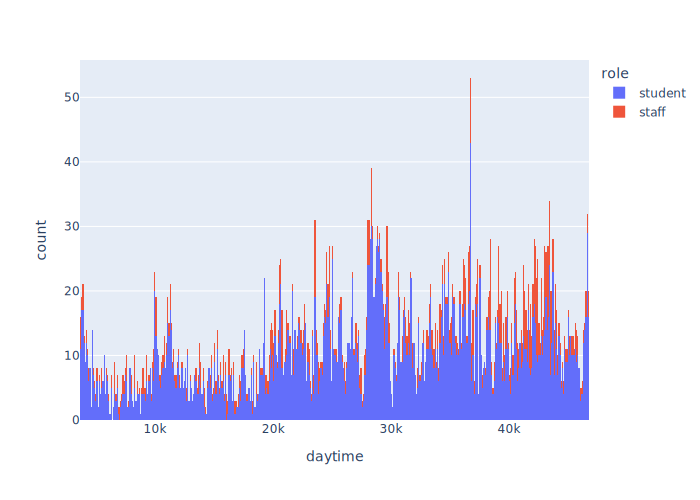

In [15]:
px.histogram(df, x = 'daytime', color = 'role', nbins=600)

## Clean up trash
Some messages are just trash. Let's find those that repeat the most.

In [16]:
q = r"""SELECT text, count(text) as cnt

        FROM df
        -- where text like '%omitted%'
        group by text
        order by cnt desc
        ;""" 

lal = sqldf(q).df()
print(lal.shape)
lal.head(30)

(4333, 2)


,text,cnt
0,image omitted,293
1,This message was deleted.,184
2,+1,91
3,Yes,55
4,No,39
5,GIF omitted,33
6,This message was deleted by admin Saurabh Sir ...,29
7,You deleted this message.,25
8,sticker omitted,19
9,https://www.linkedin.com/in/mohammad-hashim-07...,17


Not all of these are trash. We will classify them into several groups.

In [17]:
dels = list(lal.loc[[0,1,5,6,7,8,11,13,15]].text)
dels

['image omitted',
 'This message was deleted.',
 'GIF omitted',
 'This message was deleted by admin Saurabh Sir Gfg.',
 'You deleted this message.',
 'sticker omitted',
 'Ok',
 'Hello sir',
 'Nope']

In [18]:
dels += ['Thanks', 'Ty', 'video omitted']

urlfile = ["https://", ".pdf", ".docx", ".png"]

dels_like = ['document omitted','This message was deleted by admin']

joined = ["added ~ ", "removed ~ ", "removed +"]

when =  [f"WHEN text = '{t}' THEN 'deleted'" for t in dels]
when += [f"WHEN text LIKE '%{t}%' THEN 'deleted'" for t in dels_like]
when += [f"WHEN text LIKE '%{t}%' THEN 'urlfile'" for t in urlfile]
when += [f"WHEN text LIKE '%{t}%' THEN 'joined'" for t in joined]


when = "\n\t".join(when)
print(when)

WHEN text = 'image omitted' THEN 'deleted'
	WHEN text = 'This message was deleted.' THEN 'deleted'
	WHEN text = 'GIF omitted' THEN 'deleted'
	WHEN text = 'This message was deleted by admin Saurabh Sir Gfg.' THEN 'deleted'
	WHEN text = 'You deleted this message.' THEN 'deleted'
	WHEN text = 'sticker omitted' THEN 'deleted'
	WHEN text = 'Ok' THEN 'deleted'
	WHEN text = 'Hello sir' THEN 'deleted'
	WHEN text = 'Nope' THEN 'deleted'
	WHEN text = 'Thanks' THEN 'deleted'
	WHEN text = 'Ty' THEN 'deleted'
	WHEN text = 'video omitted' THEN 'deleted'
	WHEN text LIKE '%document omitted%' THEN 'deleted'
	WHEN text LIKE '%This message was deleted by admin%' THEN 'deleted'
	WHEN text LIKE '%https://%' THEN 'urlfile'
	WHEN text LIKE '%.pdf%' THEN 'urlfile'
	WHEN text LIKE '%.docx%' THEN 'urlfile'
	WHEN text LIKE '%.png%' THEN 'urlfile'
	WHEN text LIKE '%added ~ %' THEN 'joined'
	WHEN text LIKE '%removed ~ %' THEN 'joined'
	WHEN text LIKE '%removed +%' THEN 'joined'


In [19]:
dels

['image omitted',
 'This message was deleted.',
 'GIF omitted',
 'This message was deleted by admin Saurabh Sir Gfg.',
 'You deleted this message.',
 'sticker omitted',
 'Ok',
 'Hello sir',
 'Nope',
 'Thanks',
 'Ty',
 'video omitted']

In [20]:
basecols = ", ".join(df.columns)
basecols

'timestamp, author, text, date, time, daytime, role'

In [21]:
q = f"""SELECT {basecols}, 'user' || cast(au.id as string) as authorAnon,
    CASE
        {when}
        ELSE role
    END as class      
    
    FROM df
    JOIN authUnq au on df.author = au.name
        
        ;""" 
print(q)

SELECT timestamp, author, text, date, time, daytime, role, 'user' || cast(au.id as string) as authorAnon,
    CASE
        WHEN text = 'image omitted' THEN 'deleted'
	WHEN text = 'This message was deleted.' THEN 'deleted'
	WHEN text = 'GIF omitted' THEN 'deleted'
	WHEN text = 'This message was deleted by admin Saurabh Sir Gfg.' THEN 'deleted'
	WHEN text = 'You deleted this message.' THEN 'deleted'
	WHEN text = 'sticker omitted' THEN 'deleted'
	WHEN text = 'Ok' THEN 'deleted'
	WHEN text = 'Hello sir' THEN 'deleted'
	WHEN text = 'Nope' THEN 'deleted'
	WHEN text = 'Thanks' THEN 'deleted'
	WHEN text = 'Ty' THEN 'deleted'
	WHEN text = 'video omitted' THEN 'deleted'
	WHEN text LIKE '%document omitted%' THEN 'deleted'
	WHEN text LIKE '%This message was deleted by admin%' THEN 'deleted'
	WHEN text LIKE '%https://%' THEN 'urlfile'
	WHEN text LIKE '%.pdf%' THEN 'urlfile'
	WHEN text LIKE '%.docx%' THEN 'urlfile'
	WHEN text LIKE '%.png%' THEN 'urlfile'
	WHEN text LIKE '%added ~ %' THEN 'joined'
	W

In [22]:
df = sqldf(q).df()
df.head()

,timestamp,author,text,date,time,daytime,role,authorAnon,class
0,2024-04-24 07:32:47,Campus Mantri 2024-25 (Unofficial) April,Messages and calls are end-to-end encrypted. N...,2024-04-24,07:32:47,27167,student,user1000,student
1,2024-04-24 07:32:47,Amritaa Sethi Mam Gfg,Amritaa Sethi Mam Gfg created this group,2024-04-24,07:32:47,27167,staff,user1001,staff
2,2024-04-24 07:47:19,Campus Mantri 2024-25 (Unofficial) April,Amritaa Sethi Mam Gfg added you,2024-04-24,07:47:19,28039,student,user1000,student
3,2024-04-24 07:47:40,Rajat Rajput,Amritaa Sethi Mam Gfg added ~ Rajat Rajput,2024-04-24,07:47:40,28060,student,user1002,joined
4,2024-04-24 07:47:41,pulkit,Amritaa Sethi Mam Gfg added ~ pulkit,2024-04-24,07:47:41,28061,student,user1003,joined


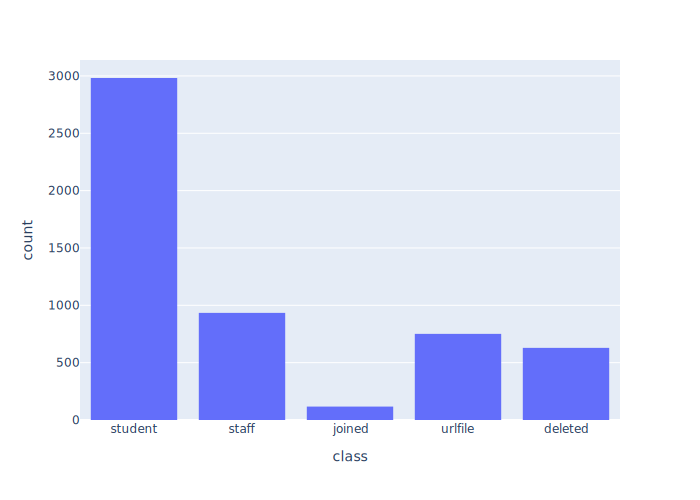

In [23]:
px.histogram(df, x = 'class')

## Visualaization
It may be interesting to view the whole data in a temporal perspective, where:
- x axis is time
- y axis are the individual users
- each dot represents a single message
- dot color is message's class

By using an interactive plotting library such as plotly, we may dive deeper into this ocean of points and perhaps discover some interesting patterns.

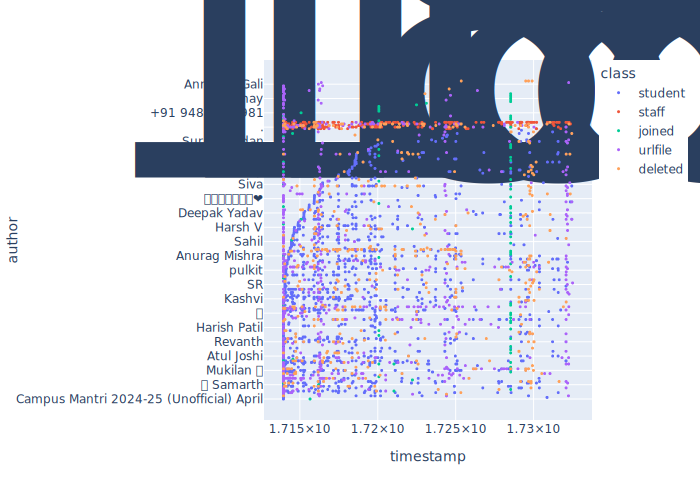

In [24]:
fig = px.scatter(df, x = "timestamp", y = "author", color = 'class', 
                 height=800, hover_data=["text"],  )
fig.update_traces(marker_size = 3)

Another interesting projection is the time vs. time-of-day:

 * Note: there was some problem with properly presenting time-of-day as HH:MM:SS, so I decided to present it as total seconds since beginning of the day.

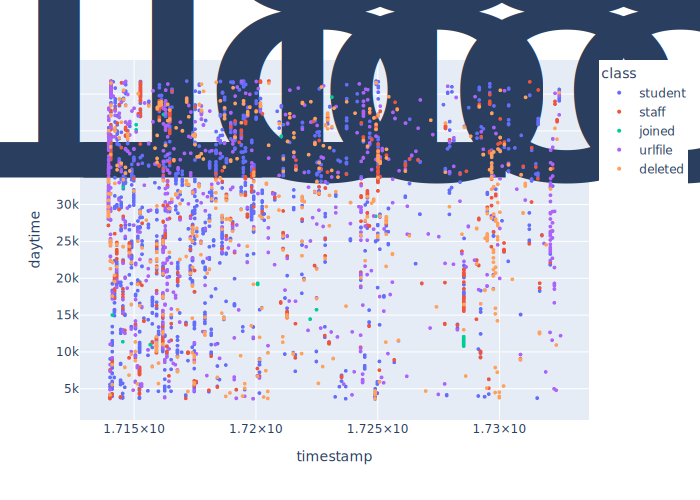

In [25]:
fig = px.scatter(df, x = "timestamp", y = "daytime", color = 'class', 
                 height=600, hover_data=["author","text"]  )

fig.update_traces(marker_size = 4)


If we zoom x axis to a resolution of one day:

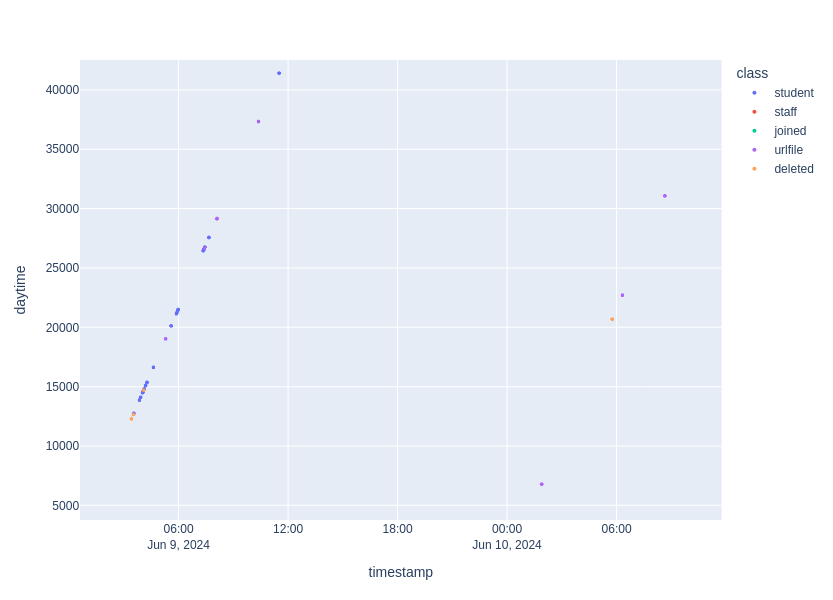

We will notice that the messages are often grouped together in separate time spans. We surmize that these are separate threads each discussing an individual topic. We think that this may be used to separate the whole dataset into a series of isolated discussions for use in a RAG.

## Filtering


In [26]:
q = f"""SELECT *

        FROM df
        where class in ('student','staff','urlfile')
        ;""" 
flt = sqldf(q).df()
flt.shape

(4667, 9)

In [27]:
flt

,timestamp,author,text,date,time,daytime,role,authorAnon,class
0,2024-04-24 07:32:47,Campus Mantri 2024-25 (Unofficial) April,Messages and calls are end-to-end encrypted. N...,2024-04-24,07:32:47,27167,student,user1000,student
1,2024-04-24 07:32:47,Amritaa Sethi Mam Gfg,Amritaa Sethi Mam Gfg created this group,2024-04-24,07:32:47,27167,staff,user1001,staff
2,2024-04-24 07:47:19,Campus Mantri 2024-25 (Unofficial) April,Amritaa Sethi Mam Gfg added you,2024-04-24,07:47:19,28039,student,user1000,student
3,2024-04-24 07:48:28,Milan Singh,https://www.linkedin.com/in/milan-s-873a80235?...,2024-04-24,07:48:28,28108,student,user1018,urlfile
4,2024-04-24 07:49:24,Revanth,https://www.linkedin.com/in/jilakararevanthkum...,2024-04-24,07:49:24,28164,student,user1021,urlfile
...,...,...,...,...,...,...,...,...,...
4662,2024-11-24 12:37:11,Shivam,Yeah! Its same for today and a day before yest...,2024-11-24,12:37:11,45431,student,user1023,student
4663,2024-11-24 12:38:12,ʀᴏᴄᴋy_ꜱᴀɪ.•°👣🔱,Thats why all got the streak issue bro 🧐,2024-11-24,12:38:12,45492,student,user1168,student
4664,2024-11-24 12:39:13,ʀᴏᴄᴋy_ꜱᴀɪ.•°👣🔱,thats what he was also asking,2024-11-24,12:39:13,45553,student,user1168,student
4665,2024-11-24 12:40:34,ʀᴏᴄᴋy_ꜱᴀɪ.•°👣🔱,"Ok no worries guys, start from today as day 1....",2024-11-24,12:40:34,45634,student,user1168,student


In [28]:
flt

,timestamp,author,text,date,time,daytime,role,authorAnon,class
0,2024-04-24 07:32:47,Campus Mantri 2024-25 (Unofficial) April,Messages and calls are end-to-end encrypted. N...,2024-04-24,07:32:47,27167,student,user1000,student
1,2024-04-24 07:32:47,Amritaa Sethi Mam Gfg,Amritaa Sethi Mam Gfg created this group,2024-04-24,07:32:47,27167,staff,user1001,staff
2,2024-04-24 07:47:19,Campus Mantri 2024-25 (Unofficial) April,Amritaa Sethi Mam Gfg added you,2024-04-24,07:47:19,28039,student,user1000,student
3,2024-04-24 07:48:28,Milan Singh,https://www.linkedin.com/in/milan-s-873a80235?...,2024-04-24,07:48:28,28108,student,user1018,urlfile
4,2024-04-24 07:49:24,Revanth,https://www.linkedin.com/in/jilakararevanthkum...,2024-04-24,07:49:24,28164,student,user1021,urlfile
...,...,...,...,...,...,...,...,...,...
4662,2024-11-24 12:37:11,Shivam,Yeah! Its same for today and a day before yest...,2024-11-24,12:37:11,45431,student,user1023,student
4663,2024-11-24 12:38:12,ʀᴏᴄᴋy_ꜱᴀɪ.•°👣🔱,Thats why all got the streak issue bro 🧐,2024-11-24,12:38:12,45492,student,user1168,student
4664,2024-11-24 12:39:13,ʀᴏᴄᴋy_ꜱᴀɪ.•°👣🔱,thats what he was also asking,2024-11-24,12:39:13,45553,student,user1168,student
4665,2024-11-24 12:40:34,ʀᴏᴄᴋy_ꜱᴀɪ.•°👣🔱,"Ok no worries guys, start from today as day 1....",2024-11-24,12:40:34,45634,student,user1168,student


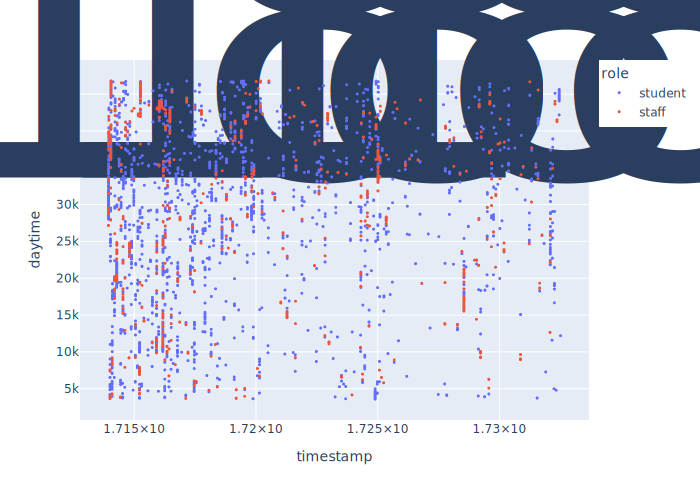

In [29]:
fig = px.scatter(flt, x = "timestamp", y = "daytime", color = 'role', 
                 height=700, hover_data=["author","text"], width=900 )
fig.update_traces(marker_size = 3)
#fig.update_layout(yaxis_tickformat='%H:%M:%S')

In [30]:
df.text.nunique()

4333

For now we will just remove only those messages that are definitely trash.  
For the conversations/dialogues separation we'll use simpler approach: just separate them by day. 

In [31]:
q = f"""
with s1 as 
(SELECT date, group_concat(time || ' ' || authorAnon || ': ' || text, '<hr>') as html_anon,
                group_concat(time || ' ' || author || ': ' || text, '<hr>') as html,
group_concat( authorAnon || ': ' || text, '\n') as txt

        FROM flt
        GROUP by date
)
select * 

from s1
order by date
        ;""" 

dialogues = sqldf(q).df()
dialogues.head()

,date,html_anon,html,txt
0,2024-04-24,07:32:47 user1000: Messages and calls are end-...,07:32:47 Campus Mantri 2024-25 (Unofficial) Ap...,user1000: Messages and calls are end-to-end en...
1,2024-04-25,01:01:13 user1067: Contemplating cool stuff to...,01:01:13 Arjun TK: Contemplating cool stuff to...,user1067: Contemplating cool stuff to execute ...
2,2024-04-26,01:06:03 user1005: Campus mantri merch ?<hr>01...,01:06:03 Pratham Pawar: Campus mantri merch ?<...,user1005: Campus mantri merch ?\nuser1144: POT...
3,2024-04-27,01:48:48 user1052: Anyone from Haryana?<hr>04:...,01:48:48 Rohit Yadav: Anyone from Haryana?<hr>...,user1052: Anyone from Haryana?\nuser1052: Guys...
4,2024-04-28,05:12:43 user1037: https://www.linkedin.com/in...,05:12:43 Hashim.exe: https://www.linkedin.com/...,user1037: https://www.linkedin.com/in/mohammad...


## Output

In [32]:

def save_df_as_pretty_html(df, filename="output.html", index=True):
    pd.set_option("display.max_colwidth", None)
    # Convert newlines to <br> for HTML
    df_html_ready = df.copy()
    for col in df_html_ready.columns:
        df_html_ready[col] = df_html_ready[col].astype(str).str.replace('\n', '<br>', regex=False)

    # Generate styled HTML
    html = df_html_ready.to_html(
        escape=False,  # Needed to render <br>
        index=index,
        border=0,
        classes="styled-table"
    )

    # Add CSS styling
    style = """
    <style>
    .styled-table {
        border-collapse: collapse;
        margin: 25px 0;
        font-size: 16px;
        font-family: Arial, sans-serif;
        width: 100%;
        table-layout: auto; /* ✅ Let browser fit naturally */
    }
    .styled-table th, .styled-table td {
        border: 1px solid #dddddd;
        padding: 10px;
        vertical-align: top;
        text-align: left;
        overflow-wrap: break-word; /* ✅ Break inside words */
        white-space: pre-wrap; /* ✅ Honor \\n linebreaks */
    }
    .styled-table td {
        max-width: 600px; /* ✅ Avoid huge dream fields expanding table */
    }
    .styled-table th {
        background-color: #f2f2f2;
    }
    </style>
    """

    # Write full HTML document
    with open(filename, "w", encoding="utf-8") as f:
        f.write(f"<!DOCTYPE html><html><head>{style}</head><body>{html}</body></html>")

    print(f"✅ HTML table saved to: {filename}")


And save it in 2 formats: 
- html for convenient viewing
- json for exporting to RAG

In [33]:
save_df_as_pretty_html(dialogues[['date','html']], 'dialogues.html')

✅ HTML table saved to: dialogues.html


In [34]:
dialogues['txt'].to_json('dialogues.json', force_ascii=False, indent=2, orient='records')

That's all for now